## AGUATHON ITA

Code based on:

## Machine Learning Mastery With Python


In [70]:
%matplotlib inline
import os
import scipy
import numpy as np
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import datetime as dt

## Fun

In [207]:
def load_rios():
    ''' 
    Load CSV using Pandas saved in current working directory
    '''
    cwd = os.getcwd()
    in_path = os.path.join(cwd,'data','ENTRADA')
    in_file = 'datos.csv'
    filename  = os.path.join(in_path,in_file)
    data = pd.read_csv(filename, parse_dates = ['time'], index_col = 'time') #, names=names)
    return data

def load_meteo(csvfile, cols):
    ''' 
    Load CSV using Pandas saved in current working directory
    '''
    cwd = os.getcwd()
    in_path = os.path.join(cwd, 'data', 'DatosPorEstacion')
    in_file = csvfile + '.csv'
    filename  = os.path.join(in_path,in_file)
    data = pd.read_csv(filename,sep=";", usecols = cols,
                       parse_dates = ['FECHA'], index_col='FECHA')
    return data

def derive_nth_day_feature(df, feature, N):
    '''
    Deriving new features using data from prior two days. That is each time series 
    shifted back 24, 48 and 72 hrs
    '''
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements
    
def level_change(df, feature, delta):
    '''
    Deriving new features using data from prior two days. That is each time series 
    shifted back 24, 48 and 72 hrs
    '''
    rows = df.shape[0]
    previous_time = [np.nan]*delta + [df[feature][i-delta] for i in range(delta, rows)]
    col_name = "{}_{}".format(feature, delta)
    df[col_name] = previous_time

### DATA LOADING

In [208]:
df_rios = load_rios()
df_rios.columns = ['Ala','Gri','Nov','Tau','Tud','Zar','Risk','P24','P48','P72']
idx = df_rios.resample('D').mean().index

# Estaciones
estaciones = {'pa1':'9262-19530901-20190131',   #pna
              'pa2':'9263D-19750101-20190302',  #pna Aerop
              'za1':'9434-19410101-20190302',   #zar Aerop
              'za2':'9244X-19920204-20190302'}  #zar Sos

cols = ['FECHA','TMEDIA','TMIN','TMAX','PRECIPITACION']
dframes = []
for k,v in estaciones.items():
    #  Read csv into a DataFrame: df
    df = load_meteo(v, cols)
    df = df.loc[idx]
    colnames = ['Tmean','rain','Tmin','Tmax']
    colnames = [x+'_'+k for x in colnames]
    df.columns = colnames 
    # Append df to frames
    dframes.append(df)

# Concatenate frames into a single DataFrame: uber
df_meteo = pd.concat(dframes, axis=1)

C:\Users\Ser\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()


In [ ]:
df_rios

### DATA PREPARATION

In [209]:
#### METEO DATA
df_meteo.fillna(value = 0,inplace=True) 
# replace string values defined by AEMET
df_meteo.replace(to_replace =['Ip','Acum'] , value =0 , inplace = True)

#Text columns to numeric
for col in df_meteo.columns:
    df_meteo[col] = pd.to_numeric(df_meteo[col], errors='coerce')

# meteo dataframe resample
df_meteo = df_meteo.resample('H').ffill()/24

### RIOS DATA
target = 'P72'
cols = ['Ala','Tud','Zar']
cols.append(target)
df_rios = df_rios[cols]

df = pd.concat([df_rios, df_meteo], axis=1)

In [210]:
#dfrain
df.head()
#dfrain[dfrain['date']=='07/08/2017']

,Ala,Tud,Zar,P72,Tmean_pa1,rain_pa1,Tmin_pa1,Tmax_pa1,Tmean_pa2,rain_pa2,Tmin_pa2,Tmax_pa2,Tmean_za1,rain_za1,Tmin_za1,Tmax_za1,Tmean_za2,rain_za2,Tmin_za2,Tmax_za2
time,,,,,,,,,,,,,,,,,,,,
2008-01-01 00:00:00,0.8100,0.7875,0.74,0.76,0.083333,0.0,-0.158333,0.329167,0.066667,0.0,-0.229167,0.3625,-0.058333,0.0,-0.104167,-0.0125,0.058333,0.0,-0.195833,0.308333
2008-01-01 01:00:00,0.8100,0.7900,0.74,0.76,0.083333,0.0,-0.158333,0.329167,0.066667,0.0,-0.229167,0.3625,-0.058333,0.0,-0.104167,-0.0125,0.058333,0.0,-0.195833,0.308333
2008-01-01 02:00:00,0.8100,0.7900,0.74,0.76,0.083333,0.0,-0.158333,0.329167,0.066667,0.0,-0.229167,0.3625,-0.058333,0.0,-0.104167,-0.0125,0.058333,0.0,-0.195833,0.308333
2008-01-01 03:00:00,0.8075,0.7900,0.74,0.76,0.083333,0.0,-0.158333,0.329167,0.066667,0.0,-0.229167,0.3625,-0.058333,0.0,-0.104167,-0.0125,0.058333,0.0,-0.195833,0.308333
2008-01-01 04:00:00,0.8000,0.7900,0.74,0.76,0.083333,0.0,-0.158333,0.329167,0.066667,0.0,-0.229167,0.3625,-0.058333,0.0,-0.104167,-0.0125,0.058333,0.0,-0.195833,0.308333


In [191]:
#df.describe()
#df.dropna(axis=0, how='any', inplace=True)

In [211]:
derived_columns = ['Tud', 'Ala']
N = 5       #number of derived columns per feature
delta = 1   # time delta in hr 
for column in derived_columns:  
    #if feature != 'date':
    for D in range(1, N + 1):
        level_change(df, column, D*delta)
#df.head() 
df.dropna(axis=0, how='any', inplace=True)
df.head()
#df.shape

,Ala,Tud,Zar,P72,Tmean_pa1,rain_pa1,Tmin_pa1,Tmax_pa1,Tmean_pa2,rain_pa2,...,Tud_1,Tud_2,Tud_3,Tud_4,Tud_5,Ala_1,Ala_2,Ala_3,Ala_4,Ala_5
time,,,,,,,,,,,,,,,,,,,,,
2008-01-01 05:00:00,0.800,0.7900,0.7400,0.76,0.083333,0.0,-0.158333,0.329167,0.066667,0.0,...,0.7900,0.7900,0.7900,0.79,0.7875,0.800,0.8075,0.8100,0.8100,0.8100
2008-01-01 06:00:00,0.800,0.7825,0.7425,0.76,0.083333,0.0,-0.158333,0.329167,0.066667,0.0,...,0.7900,0.7900,0.7900,0.79,0.7900,0.800,0.8000,0.8075,0.8100,0.8100
2008-01-01 07:00:00,0.795,0.7800,0.7500,0.76,0.083333,0.0,-0.158333,0.329167,0.066667,0.0,...,0.7825,0.7900,0.7900,0.79,0.7900,0.800,0.8000,0.8000,0.8075,0.8100
2008-01-01 08:00:00,0.790,0.7750,0.7500,0.76,0.083333,0.0,-0.158333,0.329167,0.066667,0.0,...,0.7800,0.7825,0.7900,0.79,0.7900,0.795,0.8000,0.8000,0.8000,0.8075
2008-01-01 09:00:00,0.790,0.7800,0.7500,0.76,0.083333,0.0,-0.158333,0.329167,0.066667,0.0,...,0.7750,0.7800,0.7825,0.79,0.7900,0.790,0.7950,0.8000,0.8000,0.8000


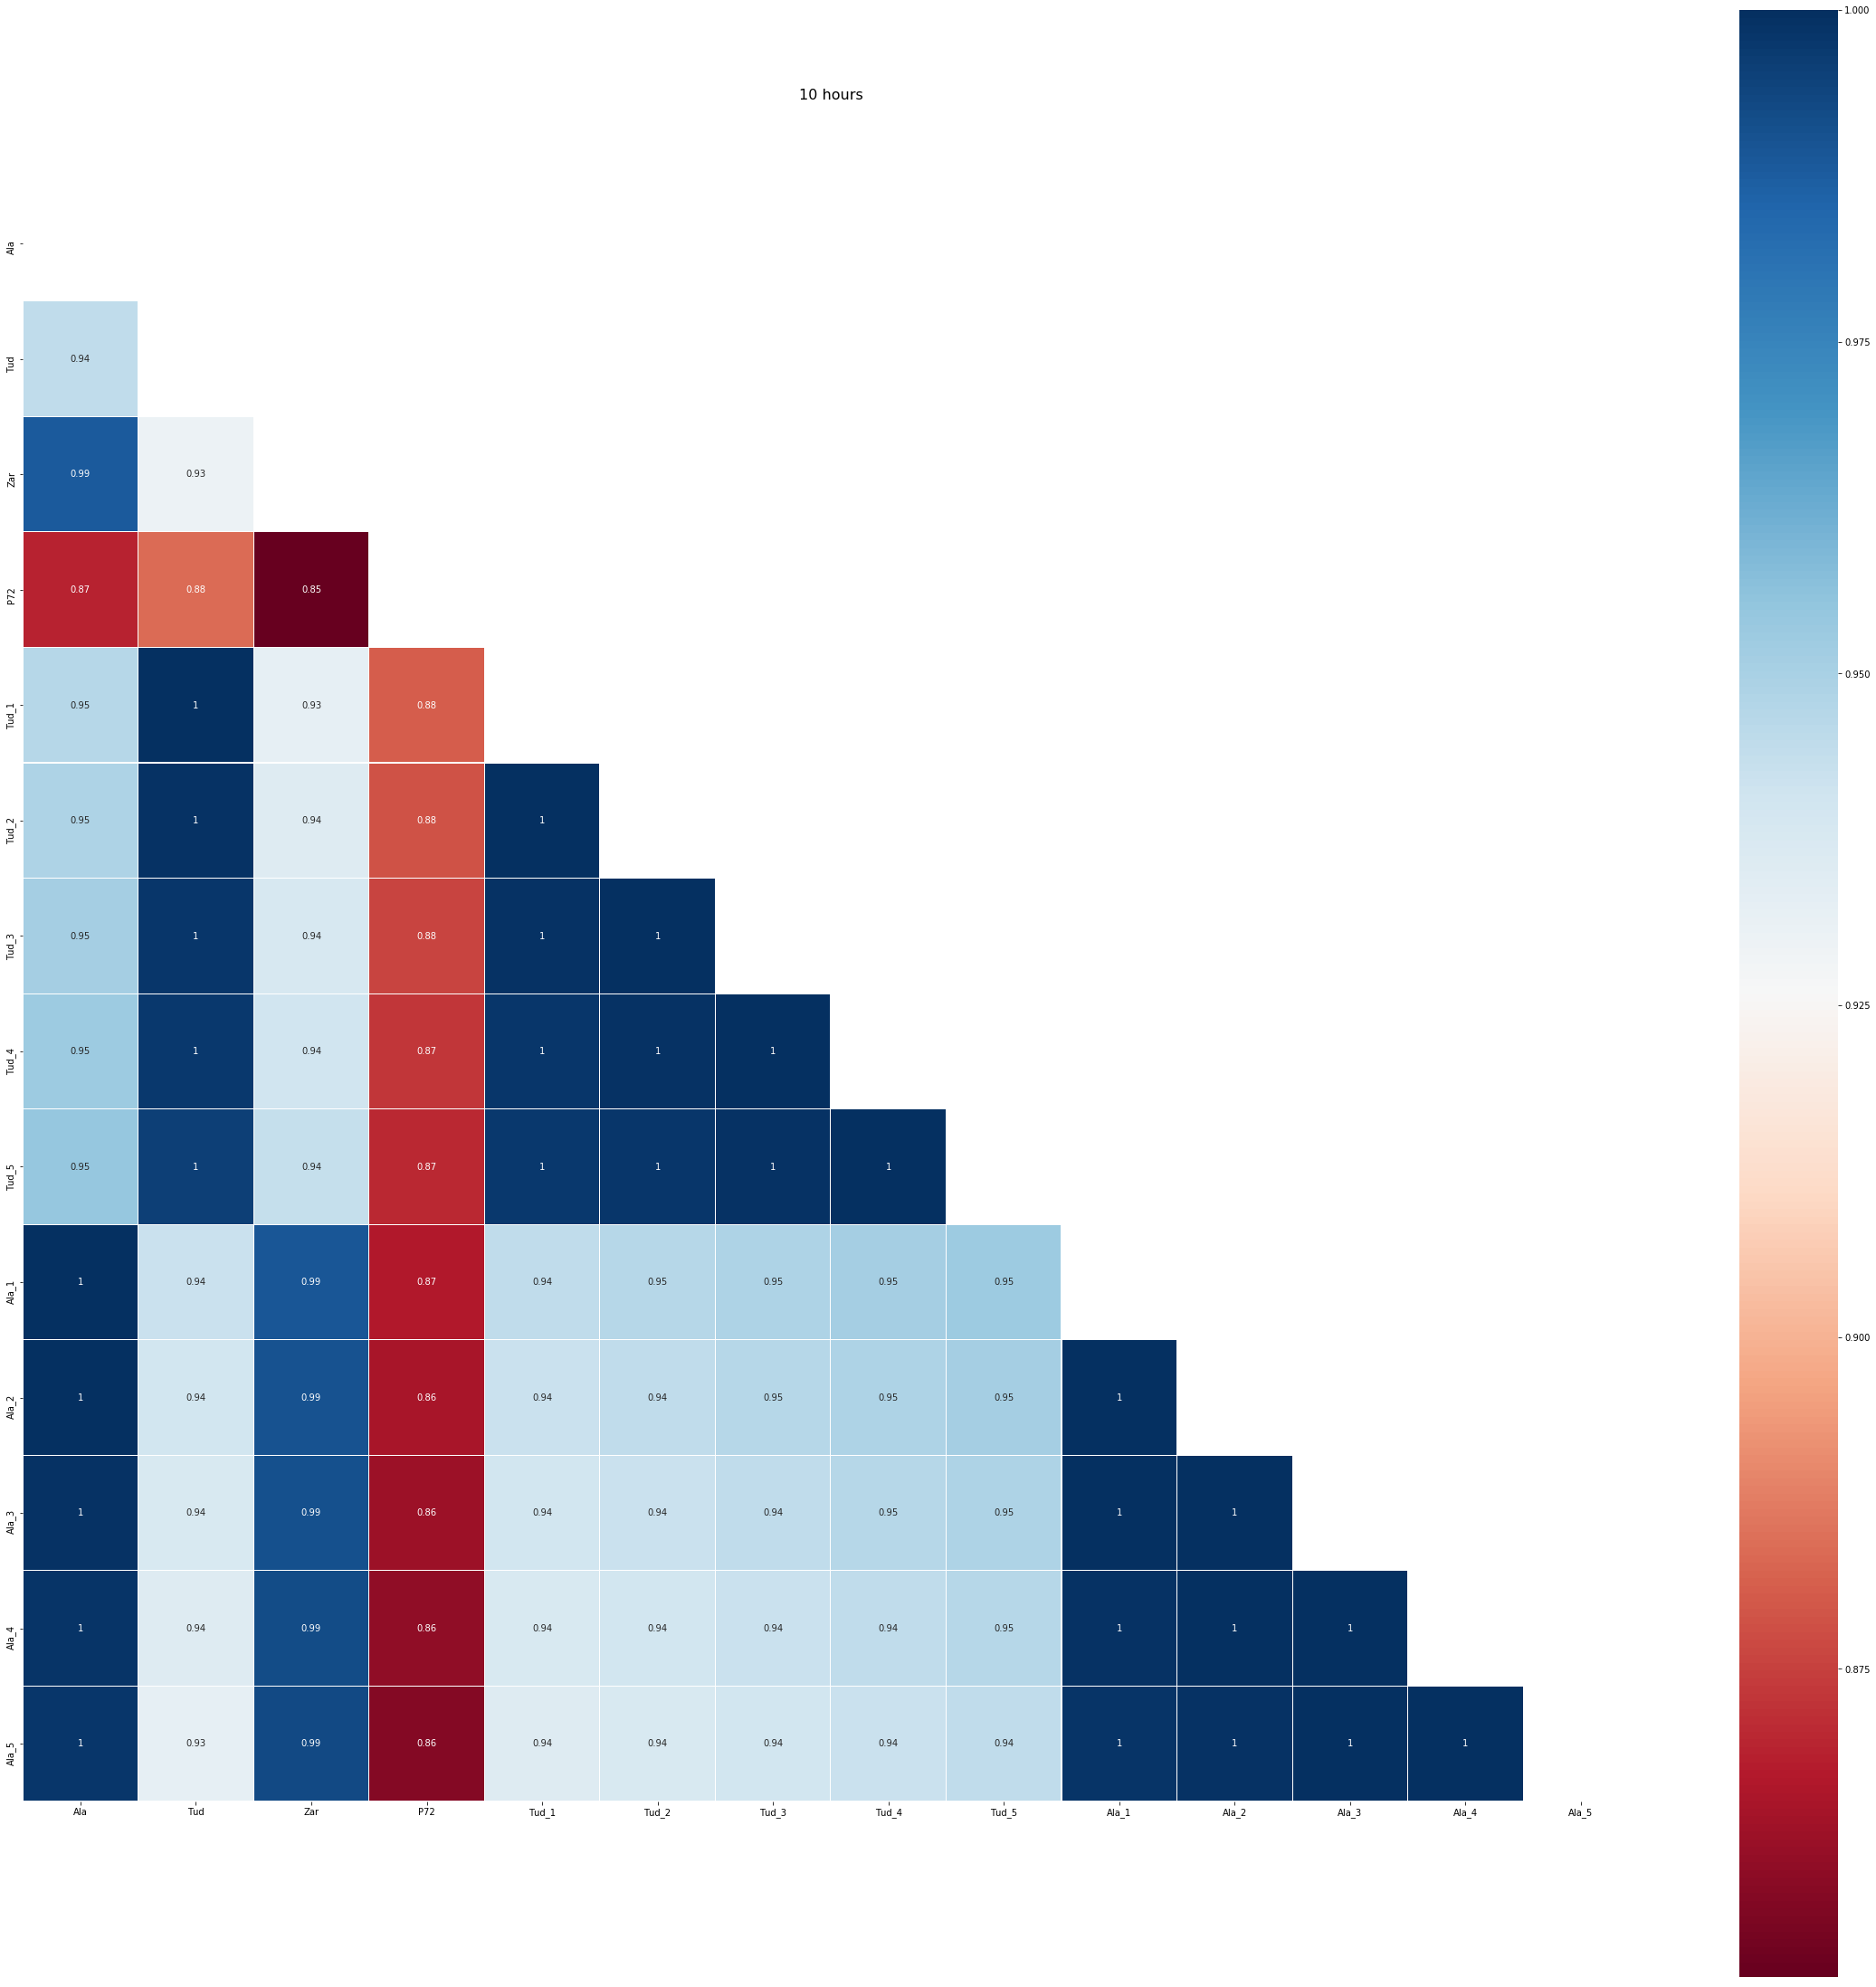

In [176]:
colormap = plt.cm.RdBu
plt.figure(figsize=(40,40))
plt.title(u'10 hours', y=1.05, size=16)

mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [212]:
features = [x for x in df.columns if x != target]
Y = df[target]
X = df.loc[:,features]#, 'Gri', 'Tau')]

### 8.1 Linear Regression
Linear regression assumes that the input variables have a Gaussian distribution. It is also
assumed that input variables are relevant to the output variable and that they are not highly
correlated with each other (a problem called collinearity).



In [213]:
# Linear Regression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


kfold = KFold(n_splits=10, random_state=7)
model = LinearRegression()
scoring = 'r2'
results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print(results.mean())

0.8318940820558114


In [68]:
# Compare Algorithms
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor


# prepare models
models = []
models.append(( 'LINR' , LinearRegression()))
models.append(( 'RDGE' , Ridge()))
#models.append(( 'KNB' , KNeighborsRegressor()))
#models.append(( 'DTR' , DecisionTreeRegressor()))
models.append(( 'GBR' , GradientBoostingRegressor()))

# evaluate each model in turn
results = []
names = []
scoring = 'r2'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = '{}: {} ({})'.format(name, cv_results.mean(), cv_results.std())
    print(msg)


LINR: 0.7879502127908753 (0.0958854633659036)
RDGE: 0.7880392993590074 (0.09566640793152247)
GBR: 0.7642143831627413 (0.10760827000180928)
